In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [4]:
#loading data and fitting follows:
img_size=7936
np.random.seed(1234567)
#loading data and fitting follows:
X_train=np.loadtxt('training_data/Xtrain_ush_short.csv',delimiter=',')
Y_train=np.loadtxt('training_data/Ytrain_ush_short.csv',delimiter=',')
#Xtrain=Xtrain[:2000]
X_train=np.transpose(X_train)
print(X_train.shape)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_train, Y_train, test_size=0.33)

(3447, 7936)


In [45]:
def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = keras.backend.random_normal(shape=keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + keras.backend.exp(log_variance/2) * epsilon
    return random_sample

In [69]:
#model defined here
inp = keras.layers.Input(shape=(img_size, 1), name="encoder_input")
#leaky reLU has been added as a separate layer than define as an activation
x1 = keras.layers.Conv1D(filters=1, kernel_size=5, padding="same", strides=2,name="encoder_conv_1")(inp)
x1 = keras.layers.BatchNormalization(name="encoder_norm_1")(x1)
x1 = keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(x1)

x1 = keras.layers.Conv1D(filters=16, kernel_size=5, padding="same", strides=2, name="encoder_conv_2")(x1)
x1 = keras.layers.BatchNormalization(name="encoder_norm_2")(x1)
x1 = keras.layers.LeakyReLU(name="encoder_leakyrelu_2")(x1)

x1 = keras.layers.Conv1D(filters=32, kernel_size=5, padding="same", strides=2, name="encoder_conv_3")(x1)
x1 = keras.layers.BatchNormalization(name="encoder_norm_3")(x1)
bp_lay_1 = keras.layers.LeakyReLU(name="encoder_leakyrelu_3")(x1)
#flatten the layers in encoder
shape_before_flatten = keras.backend.int_shape(bp_lay_1)[1:]
x2 = keras.layers.Flatten(name="flat_1")(bp_lay_1)

latent_space_dim = 4
#declare a mean and variance for the distribution
encoder_mu = keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(x2)
encoder_log_variance = keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(x2)
encoder_op = keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

encoder = keras.models.Model(inp, encoder_op, name="encoder_model")
encoder.summary()

Model: "encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 7936, 1)]    0                                            
__________________________________________________________________________________________________
encoder_conv_1 (Conv1D)         (None, 3968, 1)      6           encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_norm_1 (BatchNormalizat (None, 3968, 1)      4           encoder_conv_1[0][0]             
__________________________________________________________________________________________________
encoder_leakyrelu_1 (LeakyReLU) (None, 3968, 1)      0           encoder_norm_1[0][0]             
______________________________________________________________________________________

In [70]:
#inp2 = keras.layers.Input(shape=shape_before_flatten, name="encoder_input")
#x3 = keras.layers.AvgPool1D(2,strides=2,name='red_comp')(bp_lay_1)
#x3 = keras.layers.Flatten(name="flat_2")(bp_lay_1)
x3 = keras.layers.concatenate([encoder_mu, encoder_log_variance])
#x3 = keras.layers.Dense(128, activation='relu')(x3)
#x3 = keras.layers.Dropout(0.1)(x3)
#x3 = keras.layers.Dense(16, activation='relu')(x3)
#x3 = keras.layers.Dropout(0.1)(x3)
x3 = keras.layers.Dense(8, activation='relu')(x3)
x3 = keras.layers.Dense(4, activation='relu')(x3)
#x3 = keras.Model(inputs=inp, outputs=x3)
#x3 = keras.layers.concatenate([encoder_mu, encoder_log_variance, x3.output])
out = keras.layers.Dense(2, activation='sigmoid')(x3)

full_model = keras.models.Model(inp,out, name="classifier")

In [71]:
encoder.load_weights('encoding_raw_7936.h5')
for l1,l2 in zip(full_model.layers[:11],encoder.layers[0:11]):
    l1.set_weights(l2.get_weights())

print(full_model.get_weights()[0])
print(encoder.get_weights()[0])

[[[-0.24962662]]

 [[ 0.32514903]]

 [[ 0.44915333]]

 [[-0.47466353]]

 [[-0.0855996 ]]]
[[[-0.24962662]]

 [[ 0.32514903]]

 [[ 0.44915333]]

 [[-0.47466353]]

 [[-0.0855996 ]]]


In [72]:
for layer in full_model.layers[0:11]:
    layer.trainable = True

full_model.summary()
full_model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(lr=0.0005),metrics=['accuracy'])

Model: "classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 7936, 1)]    0                                            
__________________________________________________________________________________________________
encoder_conv_1 (Conv1D)         (None, 3968, 1)      6           encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_norm_1 (BatchNormalizat (None, 3968, 1)      4           encoder_conv_1[0][0]             
__________________________________________________________________________________________________
encoder_leakyrelu_1 (LeakyReLU) (None, 3968, 1)      0           encoder_norm_1[0][0]             
_________________________________________________________________________________________

C:\Users\ushas\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [73]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
classify_train = full_model.fit(Xtrain, Ytrain, batch_size=128,epochs=100,verbose=1,validation_split=0.2,shuffle=True,callbacks=[es_callback])

Epoch 1/100
 1/15 [=>............................] - ETA: 47s - loss: 0.9055 - accuracy: 0.4609

KeyboardInterrupt: 

In [ ]:
full_model.save_weights('autoencoder_classification.h5')

In [63]:
from sklearn.metrics import classification_report, confusion_matrix
test_loss, test_acc = full_model.evaluate(np.array(Xtrain), np.array(Ytrain))
print('Test accuracy:', test_acc)
Ypred_raw=full_model.predict(np.array(Xtrain))
Ypred=np.argmax(Ypred_raw, axis=1)
Ytest_new=np.argmax(Ytrain,axis=1)
cm = confusion_matrix(Ytest_new, Ypred)
print(cm)

73/73 [==============================] - 2s 25ms/step - loss: 0.4914 - accuracy: 0.8692
Test accuracy: 0.8692074418067932
[[ 833  132]
 [ 170 1174]]


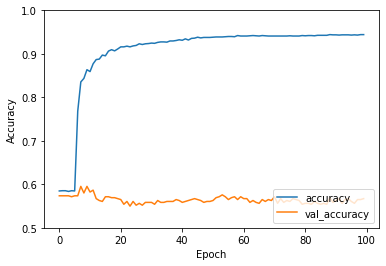

In [66]:
import matplotlib.pyplot as plt
plt.plot(classify_train.history['accuracy'], label='accuracy')
plt.plot(classify_train.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

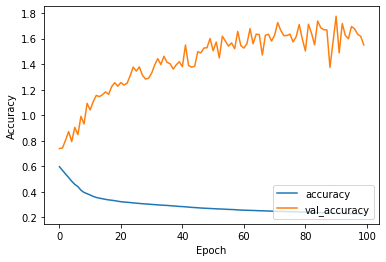

In [68]:
plt.plot(classify_train.history['loss'], label='accuracy')
plt.plot(classify_train.history['val_loss'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')